# 03. Supervised learning introduction, K-Nearest Neighbors (KNN)

In [1]:
import os
import sys
import datetime
import numpy as np
import pandas as pd
from tabulate import tabulate
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import display

In [2]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [3]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 1. Read data

The provided three files (glass.data, glass.tag, glass.names) contains a small dataset. "[The study of classification of types of glass was motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!](https://archive.ics.uci.edu/ml/datasets/Glass+Identification)"

 - read the content of the glass.data file as a pandas dataframe
 - use the column names found in the glass.names file
 - if needed, handle the missing values
 - get rid of the ID column
 - separate the GlassType from the dataset and store it in a one-hot encoded manner (if we have 3 classes, than instead of 1, 2, 3 we use [1, 0, 0], [0, 1, 0] and [0, 0, 1]. So each dimension represents a class and 1 means the sample belongs to that class, 0 is the opposite)
    - be careful, the data contains only 1-2-3-5-6-7, 4 is missing! Convert 5 $\to$ 4, 6 $\to$ 5 and 7 $\to$ 6 and then apply the one-got encoding
    - also keep the converted labels, where y is 1-2-3-4-5-6, we will need them later

### 1./a. Load dataset

In [4]:
os.listdir(data)

['glass.data', 'glass.names', 'glass.tag']

By inspecting the data files in an IDE we see the following structure:

![data_files](./img/data_files.png "Content of datafiles")

1. The `glass.data` file contains exactly $\mathbf{1}$ index column (indeces from $1$ to $214$) and $\mathbf{10}$ data columns, with no NaN values whatsover.
2. The `glass.names` file contains descriptive information about the content of the `glass.data` file. The meaning for each data columns could be found under the `7. Attribute Information` section, which is the following:
    >```
    7. Attribute Information:
       1. Id number: 1 to 214
       2. RI: refractive index
       3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as 
                      are attributes 4-10)
       4. Mg: Magnesium
       5. Al: Aluminum
       6. Si: Silicon
       7. K: Potassium
       8. Ca: Calcium
       9. Ba: Barium
      10. Fe: Iron
      11. Type of glass: (class attribute)
          -- 1 building_windows_float_processed
          -- 2 building_windows_non_float_processed
          -- 3 vehicle_windows_float_processed
          -- 4 vehicle_windows_non_float_processed (none in this database)
          -- 5 containers
          -- 6 tableware
          -- 7 headlamps
    ```
3. The `glass.tag` file should not be used currently.

In [5]:
# Collect the 10 data column names from the `glass.names` file,
# listed under the `7. Attribute Information` section
features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

In [6]:
df = pd.read_csv(data + 'glass.data',
                 sep=',', names=features, index_col=0)

In [7]:
display(df.head())
display(df.tail())

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
210,1.51623,14.14,0.0,2.88,72.61,0.08,9.18,1.06,0.0,7
211,1.51685,14.92,0.0,1.99,73.06,0.00,8.40,1.59,0.0,7
212,1.52065,14.36,0.0,2.02,73.42,0.00,8.44,1.64,0.0,7
213,1.51651,14.38,0.0,1.94,73.61,0.00,8.48,1.57,0.0,7
214,1.51711,14.23,0.0,2.08,73.36,0.00,8.62,1.67,0.0,7


### 1./b. One-hot encode column `Type`

#### Re-label types

As it was asked, I first revamp the numbering of the column `Type`, by making it consecutive.

In [8]:
def relabel_numbering(X):
    """
    Changes an input 1D array of non-negative integers in ascending order by changing the values of integers to make them consecutive.

    Parameters:
    -----------
    X : array-like of shape (N, 1)
        Array of `N` non-negative integers in ascending order.

    Returns:
    --------
    X_new : `numpy.array`
        The new array with already replaced values.
    """
    assert np.array(X).ndim == 1, "Input array-like object should be 1 dimensional, while\
                                   input dim. is ({0})!".format(np.array(X).ndim)
    
    # Collect numbers in old array
    X_nums = set(X)
    # Create a new set of consecutive numbers
    X_new_nums = set(i+1 for i in range(len(X_nums)))
    # Map the new values on the old ones
    X_new = pd.Series(X).map({x : x_n for (x, x_n) in zip(X_nums, X_new_nums)}).values
    
    return X_new

In [9]:
X_new = relabel_numbering(X=df['Type'])
# Relabel actual dataset `df`
df['Type'] = X_new

#### One-hot encode relabeled column `Type`

In [10]:
# Keep old (already relabeled) column separately but rename the variable it's stored in
type_orig = X_new
# Create the one-hot encoding using the built-in function from `pandas`
type_one_hot = pd.get_dummies(df['Type'], prefix='Type')
display(type_one_hot.head())

,Type_1,Type_2,Type_3,Type_4,Type_5,Type_6
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
5,1,0,0,0,0,0


### 1./c. Explore dataset

In [11]:
def plot_distribution(df, log_scale=False):
    """
    Plots the distribution of feature values in individual columns of a pandas DataFrame.
    
    Parameters:
    -----------
    df : `pandas.DataFrame`
        Input DataFrame to get feature values from.
        
    log_scale : bool
        Sets whether the Y-axis is displayed on a log-scale or not.
    """
    cols = df.columns
    ncols = 3
    nrows = (len(cols)-1)//ncols + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i][j]
            if i*ncols + j < len(cols):
                feature = cols[i*ncols + j]
                # `Type` is a discrete feature and needs to be treated specially
                if feature == 'Type':
                    XY = df[feature].value_counts(sort=False, normalize=False)
                    X = np.array(XY.index)
                    Y = np.array(XY.values)
                    width = 1.0
                # Else simply bin the continuous features and plot on a histogram
                else:
                    Y, bins = np.histogram(df[feature], bins=10, density=False)
                    width = 1.0 * np.diff(bins).min()
                    X = (bins[:-1] + bins[1:]) / 2
            
                ax.bar(X, Y, width=width,
                       color='tab:blue', alpha=0.8,
                       ec='black', lw=0.5, ls='--')
                ax.set_title('Feature [\'{0}\']'.format(feature),
                             fontsize=axistitlesize, fontweight='bold')
                ax.set_xlabel('Feature values', fontsize=axislabelsize, fontweight='bold')
                ax.set_ylabel('Counts', fontsize=axislabelsize, fontweight='bold')
                ax.tick_params(axis='both', which='major', labelsize=axisticksize)
                
                if log_scale:
                    ax.set_yscale('log')
                
            else:
                ax.axis('off')
                
    plt.suptitle('Fig. 1. Distribtion of feature values in the Glass Identification Database. For all continuous features\n' +
                 'a bin count of 10 was considered, while simply the value count was plotted in case of the discrete `Type` feature.',
                 fontsize=axistitlesize+6, y=0.08)
    plt.show()

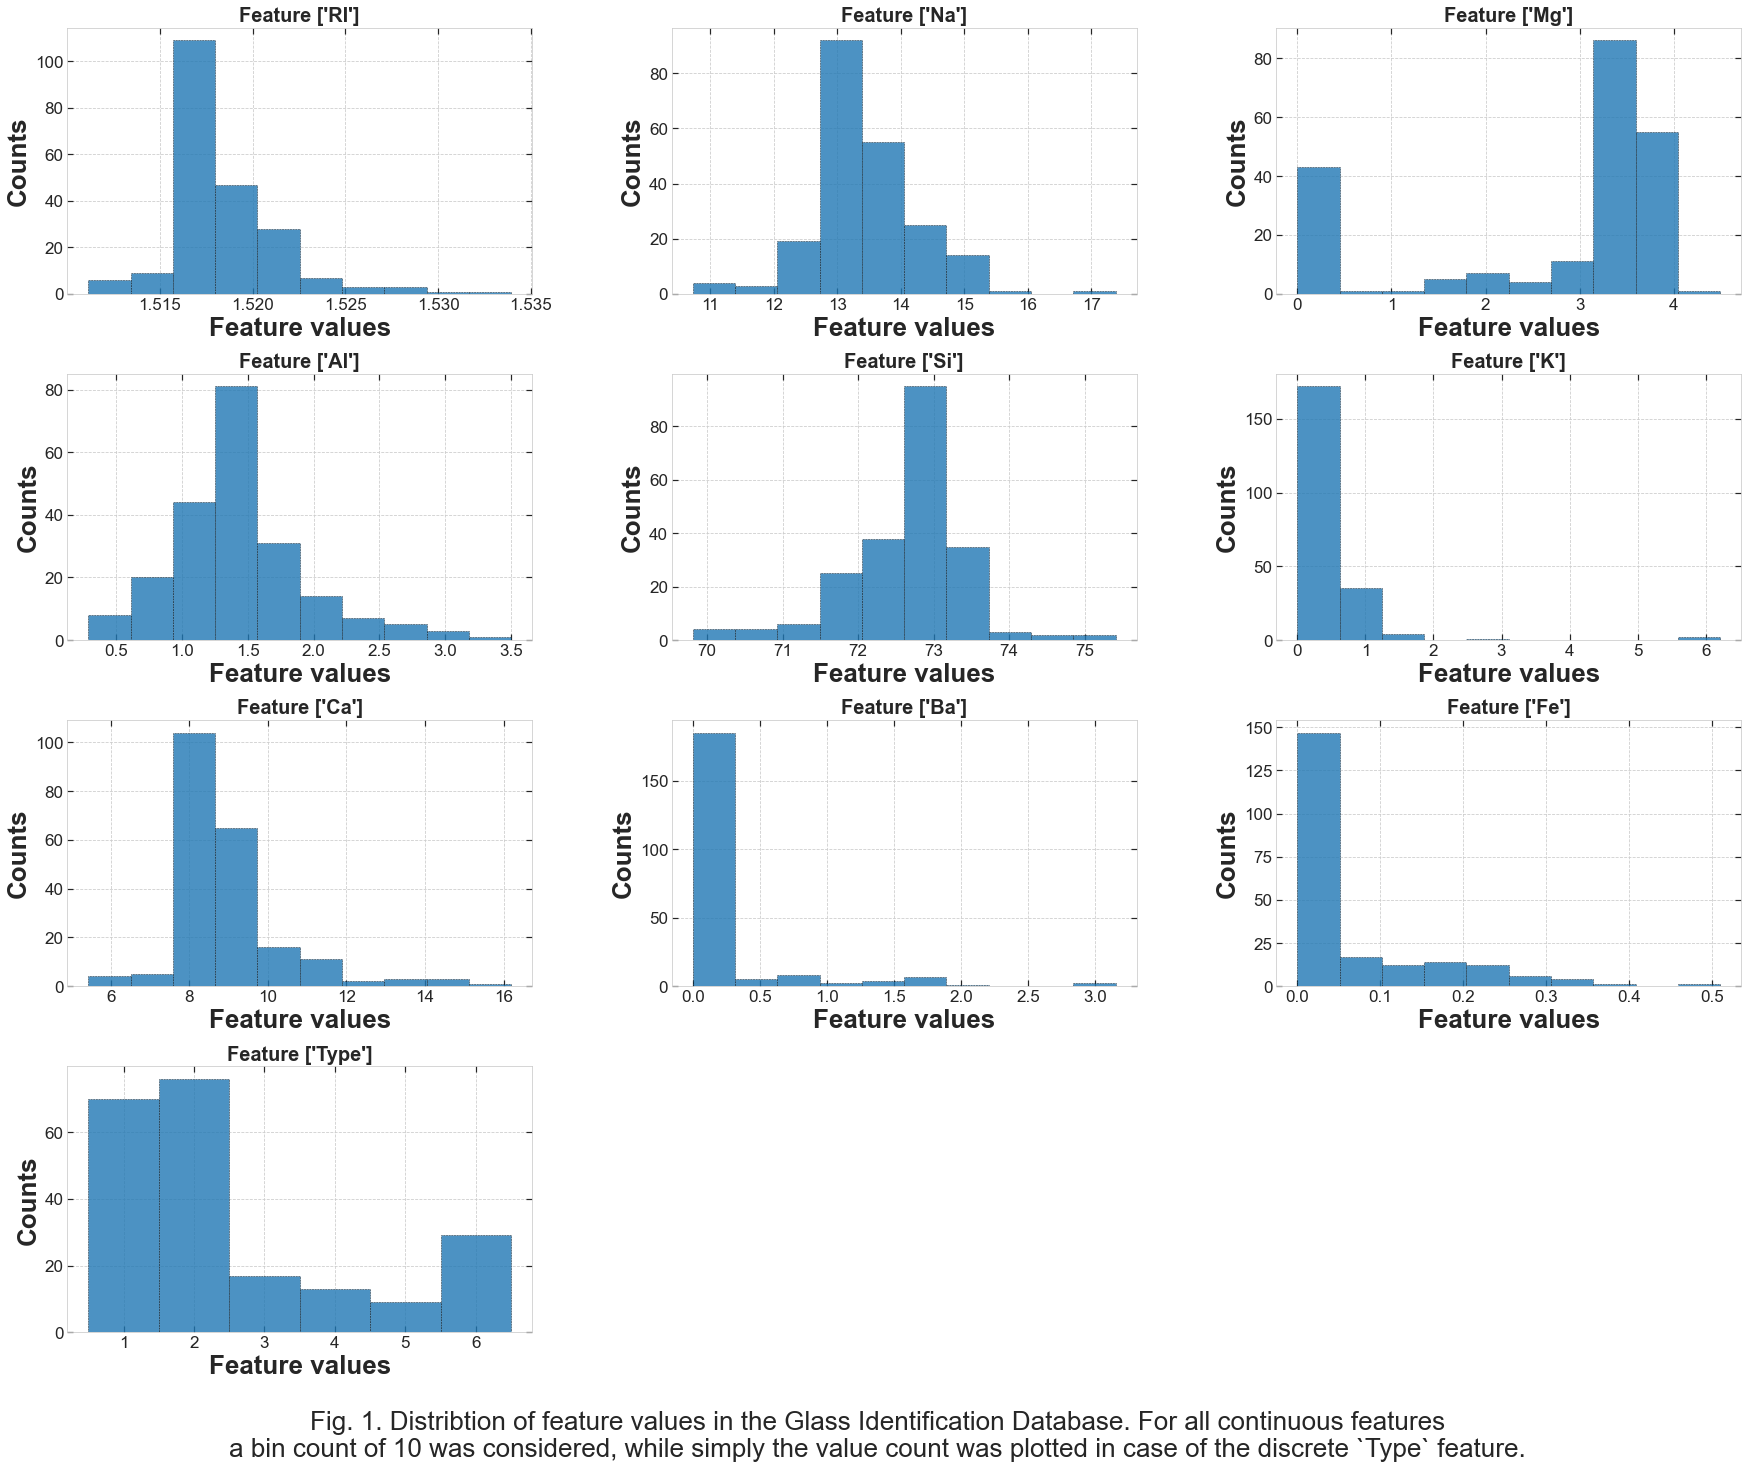

In [12]:
plot_distribution(df, log_scale=False)

In [13]:
def plot_phase_space(df):
    """
    Plots the phase space of feature values in individual columns of a pandas DataFrame.
    
    Parameters:
    -----------
    df : `pandas.DataFrame`
        Input DataFrame to get feature values from.
    """
    cols = df.columns
    nrows = len(cols)
    ncols = len(cols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*8))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i][j]
            if i < j:
                X = df[cols[i]]
                Y = df[cols[j]]
                ax.scatter(X, Y)

                ax.set_xlabel('Feature : [\'{0}\']'.format(cols[i]),
                              fontsize=axislabelsize, fontweight='bold')
                ax.set_ylabel('Feature : [\'{0}\']'.format(cols[j]),
                              fontsize=axislabelsize, fontweight='bold')
                ax.tick_params(axis='both', which='major', labelsize=axisticksize)
                
            else:
                ax.axis('off')
    
    plt.suptitle('Fig. 2. Phase space of all available features in the Glass Identification Database. It is interesting to note,\n' +
                 'that there is a clear correlation between the refractive index and calcium content of glasses.',
                 fontsize=axistitlesize+46, y=0.17)
    plt.show()

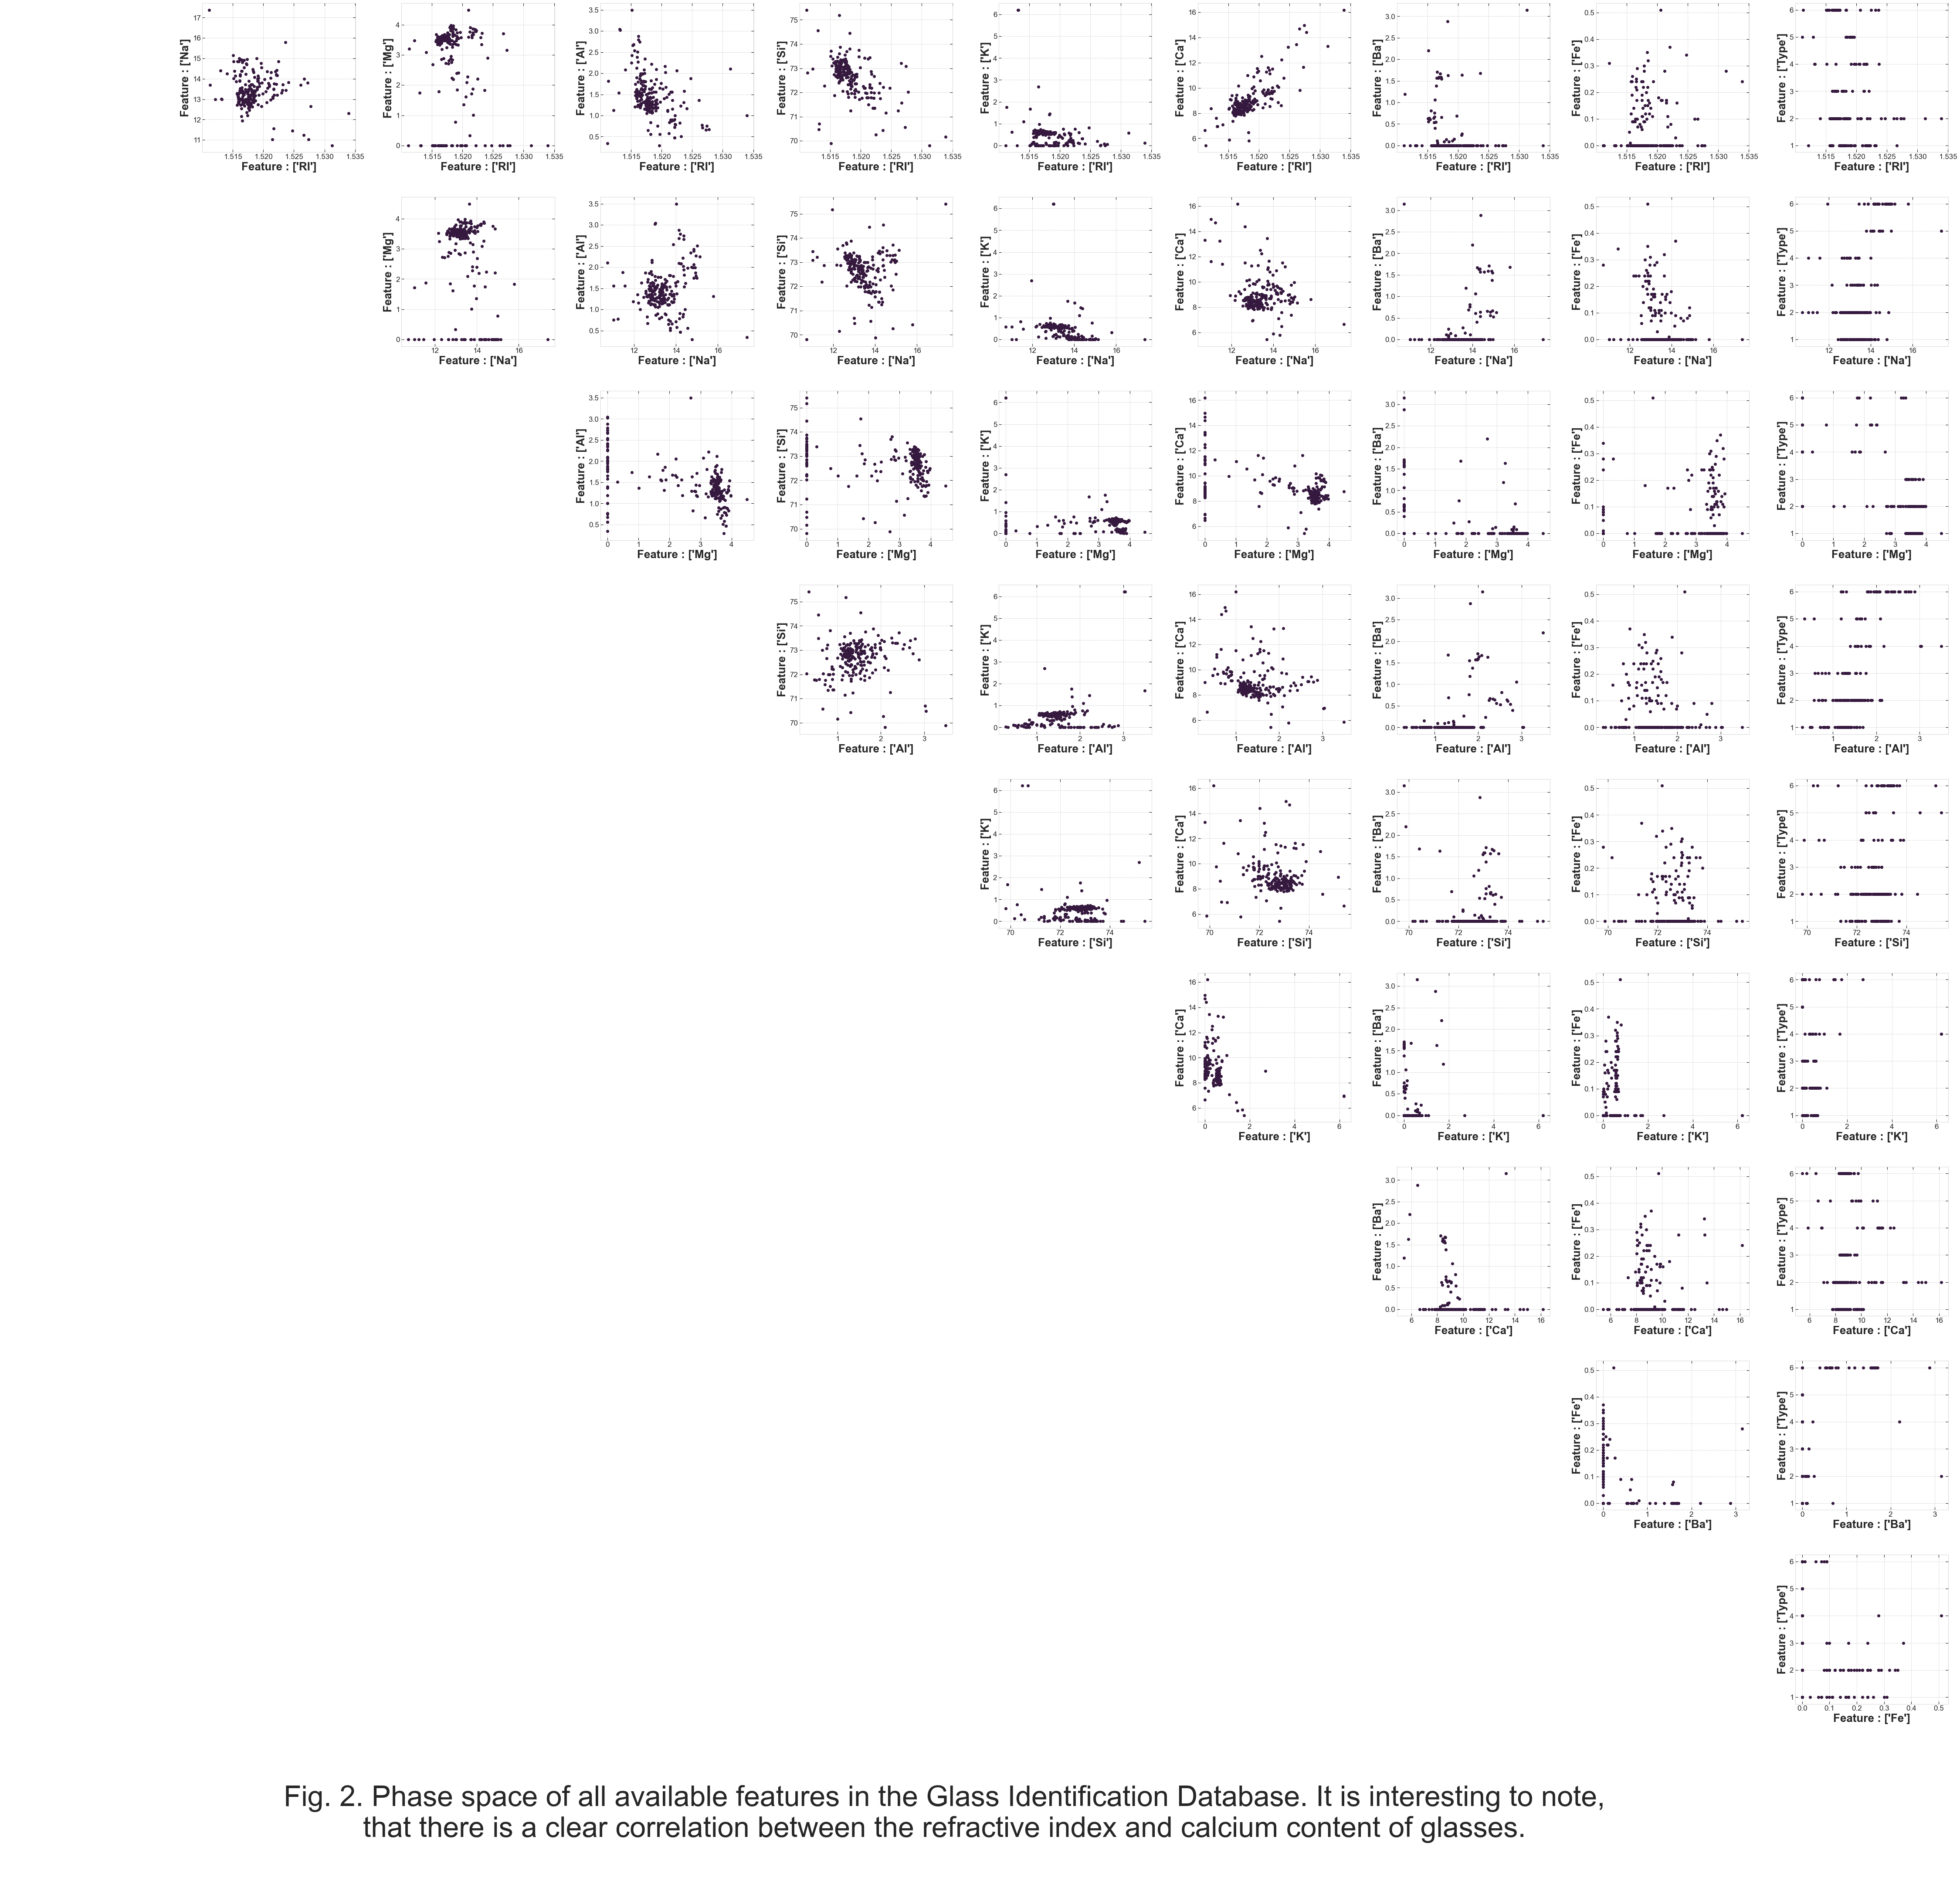

In [14]:
plot_phase_space(df)

## 2. \& 3. Implement KNN

Implement the K-nearest neighbors regression algorithm using only pure Python3 and numpy! Use L2 distance to find the neighbors. The prediction for each class should be the number of neighbors supporing the given class divided by **k** (for example if **k** is 5 and we have 3 neighbors for class A, 2 for class B and 0 for class C neighbors, then the prediction for class A should be 3/5, for class B 2/5, for class C 0/5). 

Complete the function!

```python
def knn_classifier(k, X_train, y_train, X_test):
    ...
    return predictions
```
 - **k** is the number of neighbors to be considered
 - **X_train** is the training data points
 - **X_test** is the test data points
 - **y_train** is the labels for the training data
 - assume that **y_test** is one-hot encoded.

A valid-syntaxed input looks like:
```python
k = 2
X_train = [[0.9, 0.2, 0.8] , [-1.2, 1.5, 0.7], [5.8, 0.0, 0.9], [6.2, 0.9, 0.9]]
y_train = [[0, 1], [0, 1], [1, 0], [0, 1]]
X_test  = [[0.8, 0.8, 0.6], [0.5, 0.4, 0.3]]
```

Here, it means that the training data consists of 4 points, each point is placed in a 3 dimensional space. And there are two possible classes for each point and there are two data points for that predictions is needed.

As it is detailed on the [Tutorials points website](https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_knn_algorithm_finding_nearest_neighbors.htm), the K-nearest neighbors (KNN) algorithm uses "feature similarity" to predict the values of new datapoints which further means that the new data point will be assigned a value based on how closely it matches the points in the training set. We can understand its working with the help of following steps:

>1. For implementing any algorithm, we need dataset. So during the first step of KNN, we must load the training as well as test data.
>2. Next, we need to choose the value of K i.e. the nearest data points. K can be any integer.
>3. For each point in the test data do the following:  
>    3.1. Calculate the distance between test data and each row of training data with the help of any of the method namely: Euclidean, Manhattan or Hamming distance. The most commonly used method to calculate distance is Euclidean.  
>    3.2. Now, based on the distance value, sort them in ascending order.  
>    3.3. Next, it will choose the top K rows from the sorted array.  
>    3.4. Now, it will assign a class to the test point based on most frequent class of these rows.

There are also a lot of details about the KNN algorithm itself, as well as a full implementations from scratch in Python on [TowardsDataScience](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761). The list above is a bit reformulated on this page as well, but I won't copy-paste that here. I'll use the list above to implement my KNN classifier. Also there are many useful helper functions on the [Machine Learning Mastery](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/) website as well.

I've written my KNN classifier to accept almost any form of input data, like labels in a one-hot encoded or in a regular 1D array manner. Both method perform completely the same, unlike `sklearn`'s KNN classifier.

In [15]:
def ln(a, b, n):
    """
    Calculates the n-norm of two input vectors
    
    Parameters:
    -----------
    a, b : `numpy.array`
        The two arrays between the n-norm should be measured
    """
    return np.linalg.norm((a - b), ord=n)

In [16]:
def scale_data(X):
    """
    Normalize the data to have zero mean and unit variance.
    
    Parameters:
    -----------
    X : ndarray or array-like in shape of (N, M)
        The unscaled dataset.
    
    Returns:
    --------
    X : ndarray in shape of (N, M)
        The already scaled dataset with zero mean and unit variance.
    """
    # Initialize
    scaler = StandardScaler()
    # Compute the mean and standard dev. and scale the dataset `X`
    X = scaler.fit_transform(X)

    return X

In [17]:
def count_values(X):
    """
    Return unique entries and number of their occurences in an N-dimensional array.
    
    Parameters:
    -----------
    X : ndarray or array-like
        Input array to find and count unique values in.
    
    Returns:
    --------
    X_unique : list of shape (U, N)
        Unique entries in the input array. `U` is the number of unique entries in the
        input array `X`.
        
    X_counts : list of shape (U)
        The number of occurences of entries in the input array `X`. The indeces in this
        list references the entries in the list `X_unique`. `U` is the number of unique
        entries in the input array `X`.
        
    X_indeces : list
        The unique elements's indeces of occurence.
    """
    X_unique = []
    X_counts = []
    X_indeces = []
    for i, x in enumerate(X):
        # Handle inconsistent behaviour with this little code
        # `x not in X_unique` throws error if `x` is a numpy array, but an integer `x`
        # cannot be converted to a list by `list(x)`, but only if `x` is an array-like object...
        if hasattr(x, "__len__"):
            x = x.tolist()
        if x not in X_unique:
            X_unique.append(x)
            X_counts.append(1)
            X_indeces.append([i])
        else:
            X_counts[X_unique.index(x)] += 1
            X_indeces[X_unique.index(x)].append(i)
    
    return X_unique, X_counts, X_indeces

In [18]:
def knn_classifier(k, X_train, y_train, X_test, scale=True):
    """
    Implements the K-nearest neighbour classifier.

    Parameters:
    -----------
    k : int
        Number of neighbors to use in the classification.

    X_train : ndarray or array-like in shape of (N, M)
        Train dataset.

    y_train : ndarray or array-like in shape of (M, P)
        Train labels in similar shape as the corresponding train dataset.

    X_test : ndarray or array-like in shape of (X, Y)
        Test dataset.

    scale : bool
        Whether to standard scale the datasets.
    
    Returns:
    --------
    predictions : 
        Predicted array of data
    """
    assert X_train.shape[0] == y_train.shape[0],\
            "Shape of train data is {0}, while shape of train labels are {1}".format(X_train.shape[0], y_train.shape[0])
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    
    # Scale data to have zero mean and unit variance
    if scale:
        X_train = scale_data(X_train)
        X_test = scale_data(X_test)
    
    y_pred = []
    # 3. For each point in the test data
    for i, test in enumerate(X_test):
        # 3.1. Calculate distance between test data and each row of training data
        #      Store indeces of training data as well
        indeces = np.zeros((len(X_train), ), dtype=int)
        dist = np.zeros((len(X_train), ), dtype=float)
        for j, train in enumerate(X_train):
            indeces[j] = j
            dist[j] = ln(a=test, b=train, n=2)
        # 3.2. Based on the distance value, sort them in ascending order along indeces
        dist, indeces = zip(*sorted(zip(dist, indeces)))
        # 3.3. Choose the top K rows from the sorted array
        top_k_points = X_train[list(indeces[:k])]
        top_k_labels = y_train[list(indeces[:k])]
        # 3.4. Assign a class to the test point based on most frequent class of these rows
        #      In the case of a tie the closest point's or point cluster's class will be chosen
        X_unique, X_counts, X_indeces = count_values(top_k_labels)
        # Get the indeces of the most frequent classes. If there is a tie, it returns indeces
        # for all top tied classes. If one class is superior, it returns indeces for only that class.
        max_indeces = [k for k, v in enumerate(X_counts) if v==np.max(X_counts)]
        # Naively we can simply return the class corresponding to the first index in this `max_indeces`
        # array. The closest point to the test query will have this class in the superior point clusters.
        # If we have only one promiment group of labels, we can simply use this method
        if len(max_indeces) == 1:
            y_pred.append(X_unique[max_indeces[0]])
        # A more robust method is to return the label corresponding to the closest point cluster
        # This is useful if we have more than one, equally prominent labels
        else:
            clust_dist = np.zeros(len(max_indeces), dtype=float)
            for i, m in enumerate(max_indeces):
                clust_dist[i] = ln(a=test, b=np.sum(top_k_points, axis=0), n=2)
            # Find label of closest cluster
            clust_dist, X_unique = zip(*sorted(zip(clust_dist, X_unique)))
            y_pred.append(X_unique[0])

    return np.array(y_pred)

In [19]:
def onehot_2_normal(X):
    """
    Convert one-hot encoded matrix to 1D array of label indeces.
    """
    return np.array([np.where(p == 1)[0][0]+1 for p in X])

In [20]:
def accuracy_metric(y_test, y_pred):
    """
    Calculate accuracy of model prediction.
    
    Parameters:
    -----------
    y_test : array-like of shape (N, )
        Original labels of the test dataset.
    
    y_pred : array-like of shape (N, )
        Predicted labels of the test dataset.
    
    Returns:
    --------
    Accuracy of model in reference of the true test labels.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    correct = 0
    for (t, p) in zip(y_test, y_pred):
        if hasattr(t, '__len__'):
            t = list(t)
            p = list(p)
        if t == p:
            correct += 1
    return correct / len(y_test) * 100

In [21]:
def plot_confusion_matrix(conf_mat, y, title=None):
    """
    Plots a confusion matrix
    """
    fig, axes = plt.subplots(figsize=(12,12))
    axes.set_aspect('equal')

    im = axes.imshow(conf_mat)
    # Loop over data dimensions and create text annotations.
    for X in range(conf_mat.shape[0]):
        for Y in range(conf_mat.shape[1]):
            axes.text(Y, X, conf_mat[X, Y], fontsize=30,
                      ha='center', va='center', color='white', fontweight='bold', 
                      bbox=dict(color=np.array((0,0,0,0.2)), lw=0)
                     )

    axes.set_xticks([i for i in range(len(set(y)))])
    axes.set_xticklabels([i+1 for i in range(len(set(y)))])
    axes.set_yticks([i for i in range(len(set(y)))])
    axes.set_yticklabels([i+1 for i in range(len(set(y)))])

    axes.set_xlabel('Predicted labels', fontsize=axislabelsize+5, fontweight='bold')
    axes.set_ylabel('True labels', fontsize=axislabelsize+5, fontweight='bold')
    axes.tick_params(axis='both', which='major', labelsize=axisticksize+5)
    axes.xaxis.tick_top()
    axes.xaxis.set_label_position('top') 

    axes.grid(False)

    # Create an axis on the right side of `axes`. The width of `cax` will be 5%
    # of `axes` and the padding between `cax` and axes will be fixed at 0.1 inch
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(mappable=im, cax=cax)
    cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='black')
    cbar.set_label('Number of occurences', fontsize=axiscbarfontsize+10, labelpad=15, rotation=90)

    plt.suptitle(title,
                 fontsize=axistitlesize+5, y=0.1)

    plt.show()

Insert the valid-syntaxed input to the KNN:

In [22]:
k = 2
X_train = np.array([[0.9, 0.2, 0.8] , [-1.2, 1.5, 0.7], [5.8, 0.0, 0.9], [6.2, 0.9, 0.9]])
y_train = np.array([[0, 1], [0, 1], [1, 0], [0, 1]])
X_test  = np.array([[0.8, 0.8, 0.6], [0.5, 0.4, 0.3]])

In [23]:
y_pred = knn_classifier(k, X_train, y_train, X_test)

## 4. Predictions & interpretation

- use every second (0, 2, 4, etc indicies) datapoint as training data and use the rest (1, 3, 5, ...) as test data
- generate predictions with the implemented KNN with k=5
- calculate the accuracy and the confusion matrix for the predictions
- if the probability is the same for two or more classes select the first one from the left in the one-hot encoded version (or which has the smallest number in the original dataset)

In [24]:
# Data
X = df[features[:-1]]
y = type_one_hot
# Neighbours for KNN
k = 5
# Prepare train and test sets
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

In [25]:
y_pred = knn_classifier(k, X_train, y_train, X_test)

In [26]:
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(onehot_2_normal(np.array(y_test)),
                            onehot_2_normal(y_pred))

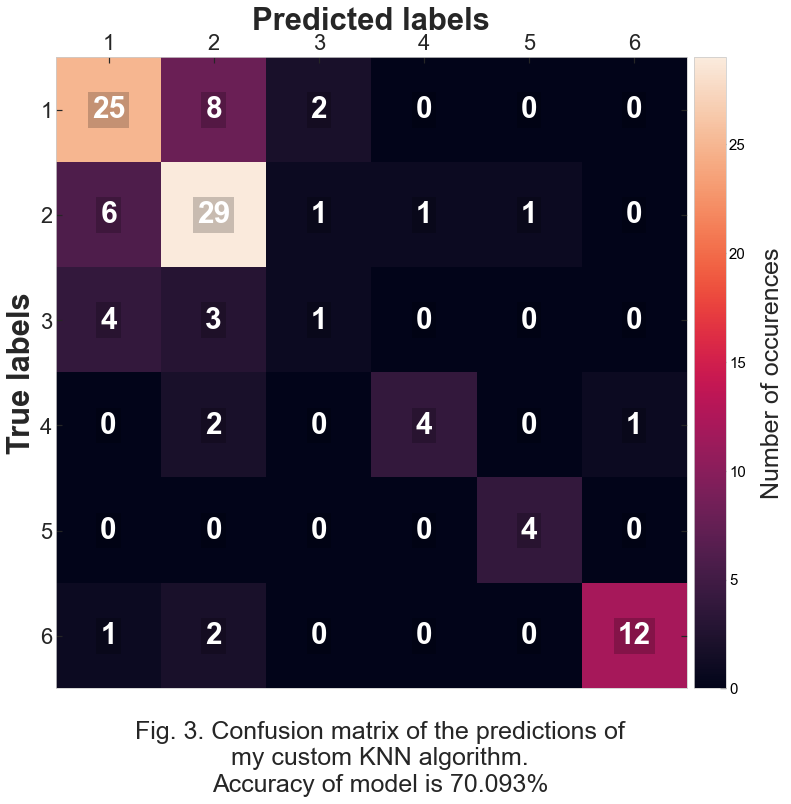

In [27]:
plot_confusion_matrix(conf_mat, y,
                      title=('Fig. 3. Confusion matrix of the predictions of\nmy custom KNN algorithm.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

## 5. Compare it to Sklearn's KNN
- using the same train/test split generate predictions with sklearn KNNs. Use 5 neighbors again
- are the predictions the same as for our implementation? (they should be)
   - note: to get sklearn perform the same algorithm as our implementation it expects you to provide non one-hot encoding labels. That's why we kept them in the first exercise

In [40]:
# Data
X = df[features[:-1]]
y = type_orig
# Neighbours for KNN
k = 5
# Prepare train and test sets
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

In [41]:
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [42]:
y_pred = neigh.predict(X_test)

In [43]:
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

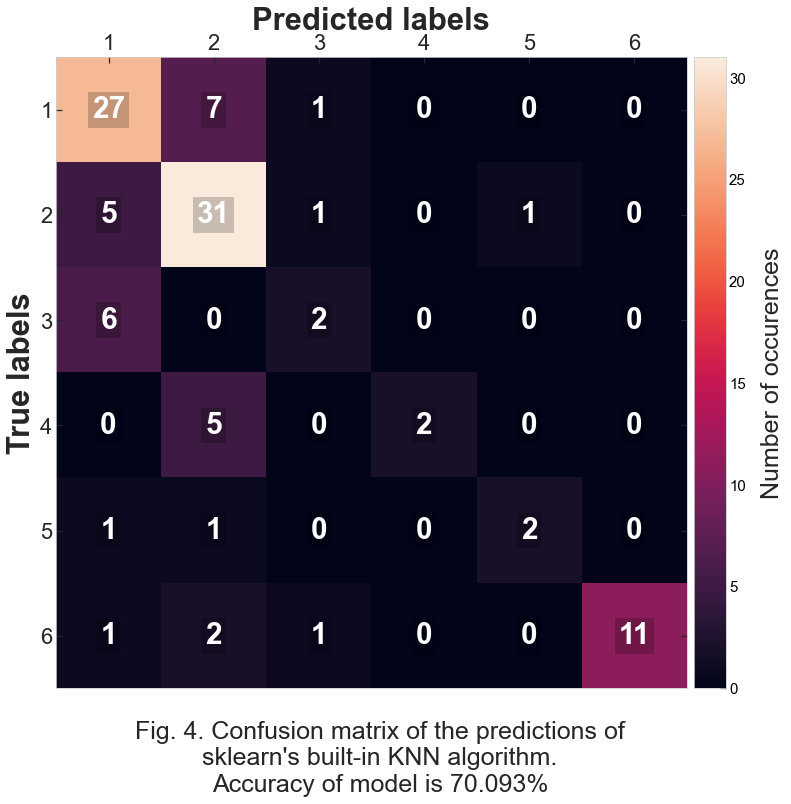

In [44]:
plot_confusion_matrix(conf_mat, y,
                      title=('Fig. 4. Confusion matrix of the predictions of\nsklearn\'s built-in KNN algorithm.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

## Summary and discussion

However there is a difference in predictions of `sklearn`'s and my own algorithm, I could manage the achieve the same accuracy as `sklearn` in this particular problem. I rejected the give advice that said "if the probability is the same for two or more classes select the first one from the left in the one-hot encoded version (or which has the smallest number in the original dataset)", since in numerous cases it could be inaccurate and would deteriorate the accuracy of my model. My more robust solution is detailed in the comments of the `knn_classifier()` function.

While `sklearn`'s algorithm is better identifying the type classes `1`, `2` and `3`, my algorithm superiors in the identification of classes `4`, `5` and `6`.

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 